In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Visualizing embedding similarity from text documents using t-SNE plots

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/embeddings/embedding-similarity-visualization.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/embeddings/embedding-similarity-visualization.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/embeddings/embedding-similarity-visualization.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Gabe Rives-Corbett](https://github.com/grivescorbett) |

This notebook demonstrates how vector similarity is relevant to LLM-generated embeddings. You will embed a collection of labelled documents and then plot the embeddings on a two-dimensional t-SNE plot to observe how similar documents tend to cluster together based on their embeddings.

## Getting started

### Install libraries

In [17]:
%pip install --user langchain==0.0.315 \
                    google-cloud-aiplatform==1.35.0 \
                    scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.3.18 requires langsmith<0.2.0,>=0.1.125, but you have langsmith 0.0.92 

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [3]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, you will need to authenticate your environment. To do this, run the new cell below. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [1]:
import sys
from google.cloud import aiplatform
if "google.colab" in sys.modules:
    # Define project information
    PROJECT_ID = "enduring-coda-440909-a8"  # @param {type:"string"}
    LOCATION = "us-central1"  # @param {type:"string"}


    aiplatform.init(project='enduring-coda-440909-a8', location='us-central1')

    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Import libraries

In [2]:
import re

from google.api_core import retry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from vertexai.language_models import TextEmbeddingModel

tqdm.pandas()

## Fetch and clean the data

In this example, you will use the open source [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset, a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups

In [3]:
categories = ["comp.graphics", "sci.space", "sci.med", "rec.sport.hockey"]
newsgroups = fetch_20newsgroups(categories=categories)

In [4]:
raw_data = pd.DataFrame()
raw_data["text"] = newsgroups.data
raw_data["target"] = [newsgroups.target_names[x] for x in newsgroups.target]

Because of the 8k input token limit, in this example you will exclude all documents that have a length outside this limit.

Even though tokens typically are >=1 characters, for simplicity, you can just filter for documents that have <= 8000 _characters_.

In [5]:
filtered = raw_data.loc[raw_data["text"].str.len() <= 8000]

Subsample the dataset into 500 data points, stratified on the label

In [6]:
x_subsample, _, y_subsample, _ = train_test_split(
    raw_data["text"], raw_data["target"], stratify=raw_data["target"], train_size=500
)

Clean out the text removing by emails, names, etc. This will help improve the data that will then be converted into embeddings.

In [7]:
x_subsample = [re.sub(r"[\w\.-]+@[\w\.-]+", "", d) for d in x_subsample]  # Remove email
x_subsample = [re.sub(r"\([^()]*\)", "", d) for d in x_subsample]  # Remove names
x_subsample = [d.replace("From: ", "") for d in x_subsample]  # Remove "From: "
x_subsample = [
    d.replace("\nSubject: ", "") for d in x_subsample
]  # Remove "\nSubject: "

In [8]:
df = pd.DataFrame()
df["text"] = x_subsample
df["target"] = list(y_subsample)

You now have 500 data points roughly evenly distributed across the categories:

In [9]:
df["target"].value_counts()

,count
target,
rec.sport.hockey,127
sci.space,125
sci.med,125
comp.graphics,123


## Create and visualize the embeddings using a t-SNE plot

Load the text embedding model from Vertex AI ([documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings)).

In [27]:
model = TextEmbeddingModel.from_pretrained("text-embedding-005")

In [28]:
# Retrieve embeddings from the specified model with retry logic


def make_embed_text_fn(model):
    @retry.Retry(timeout=300.0)
    def embed_fn(text):
        return model.get_embeddings([text])[0].values

    return embed_fn

Create the embeddings. This may take a minute or two.

In [29]:
df["embeddings"] = df["text"].progress_apply(make_embed_text_fn(model))

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
df.head()

,text,target,embeddings
0,Re: Vandalizing the sky.\nReply-To: \nDisclai...,sci.space,"[-0.02764451876282692, -0.0048937504179775715,..."
1,Loosing color.\nLines: 9\n\nHi guys.\n\nI am s...,comp.graphics,"[-0.0369870625436306, 0.003079553134739399, 0...."
2,Re: SIGGRAPH\nSummary: No free lunch this yea...,comp.graphics,"[0.009136992506682873, -0.07585234940052032, 0..."
3,Lawrence Curcio <lc2b+@andrew.cmu.edu>Re: Big ...,sci.space,"[-0.023690607398748398, 0.04453451186418533, 0..."
4,Gamma-Law Correction\nOrganization: Project G...,comp.graphics,"[-0.012492583133280277, -0.011236145161092281,..."


The vectors generate by our model are 768 dimensions, and so visualizing across 768 dimensions is impossible. Instead, you can use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to reduce to 2 dimensions.

In [31]:
embeddings_array = np.array(df["embeddings"].to_list(), dtype=np.float32)
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings_array)

In [32]:
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne["target"] = df["target"]  # Add labels column from df_train to df_tsne

In [33]:
df_tsne.head()

,TSNE1,TSNE2,target
0,15.066490,-0.342780,sci.space
1,10.652645,-37.411461,comp.graphics
2,-0.710037,-21.979269,comp.graphics
3,25.722347,7.828348,sci.space
4,3.488177,-34.722595,comp.graphics


Plot the data points. It should now be visually clear how the documents from the same newsgroup show up close to each other in the vector space with text embeddings.

(-46.857367515563965,
 36.191805839538574,
 -44.19073696136475,
 37.61240978240967)

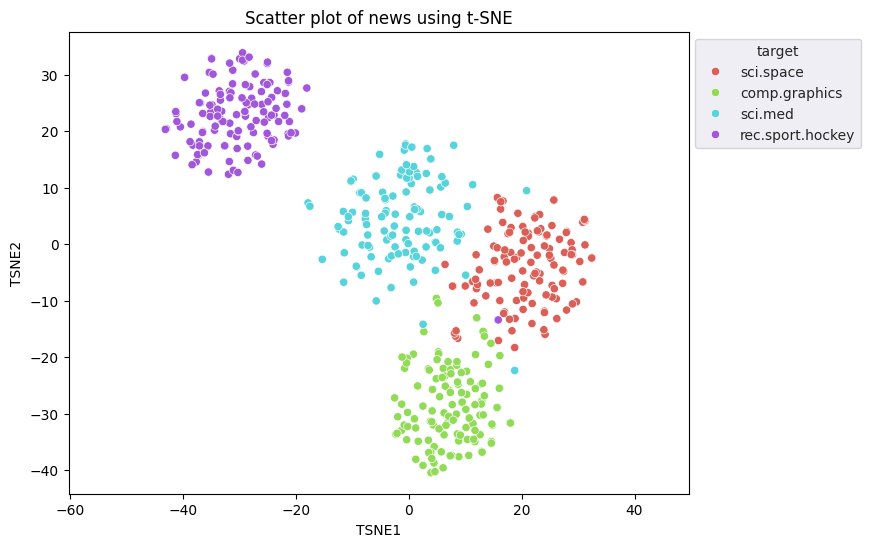

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="target", palette="hls")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")